# Optimizing stixel size

Yangkang Chen<br>
Jan 12, 2024

This notebook is to explore why and how we should tune the gridding hyperparameters of the Quadtree algorithm.

## Why should we even care about the grid size parameter?

As mentioned in [the brief introduction to `stemflow`](https://chenyangkang.github.io/stemflow/A_brief_introduction/A_brief_introduction.html), the main target of `AdaSTEM` modeling framework is to solve the long-distance/long-range prediction problem.

This is realized by gridding data into smaller spatial and temporal grids (that is what `temporal sliding window` and spatial `Quadtree algorithm` are doing), so that each prediction will only rely on the trained adjacency information in space and time.

It is similar to the concept of `spatial regression` or `spatial/temporal lag`, only that in our cases the lag is a sharp truncation (but after averaging across ensembles, the edge will be soften).

Using two extreme examples we can tell the necessity of set good gridding parameters:
- Extremely large: Imagine if you set extremely large sliding window interval and grid size for Quadtree algo – there will be only one stixel. That is, it's equivalent to bulk regression without partitioning. Apparently this is not what we want.
- Extremely small: Imagine the grids are extremely small that each grid only contains one sample – That will be an 100% overfitting.

Therefore, we need to assess which parameter setting is best for our modeling goal: to 

- 1. improve the model performance
- 2. avoid overfitting 
- 3. reach a balance between accuracy and efficienty





In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import matplotlib
import warnings
import pickle
import os
import time


In [2]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import time

from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle

# warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

## Download data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

## Load data

In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


In [5]:
data.head()

,longitude,latitude,count,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,...,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,0.0,22,300.0,1,0,0,4.828,5.0,...,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,9.0,290,90.0,1,0,0,0.570,2.0,...,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,0.0,141,10.0,0,1,0,-1.000,2.0,...,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,0.0,104,9.0,1,0,0,0.805,2.0,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,2.0,96,30.0,1,0,0,0.161,2.0,...,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


## Train AdaSTEMRegressor with hurdle model as base model

`stemflow` have 2 important gridding parameters: The maximum grid length, and the minimum grid length.

Now we set the gradient that we want to explore: `5, 10, 25, 50, and 100` degree units.


In [6]:
import itertools

# Create the parameter grid ensuring the upper threshold is greater than the lower threshold
params = [
    {'grid_len_lower_threshold': [lower], 'grid_len_upper_threshold': [upper]}
    for lower, upper in itertools.product([5, 10, 25, 50, 100], [5, 10, 25, 50, 100])
    if upper > lower
]

print('Gridsearch params: ',params)


Gridsearch params:  [{'grid_len_lower_threshold': [5], 'grid_len_upper_threshold': [10]}, {'grid_len_lower_threshold': [5], 'grid_len_upper_threshold': [25]}, {'grid_len_lower_threshold': [5], 'grid_len_upper_threshold': [50]}, {'grid_len_lower_threshold': [5], 'grid_len_upper_threshold': [100]}, {'grid_len_lower_threshold': [10], 'grid_len_upper_threshold': [25]}, {'grid_len_lower_threshold': [10], 'grid_len_upper_threshold': [50]}, {'grid_len_lower_threshold': [10], 'grid_len_upper_threshold': [100]}, {'grid_len_lower_threshold': [25], 'grid_len_upper_threshold': [50]}, {'grid_len_lower_threshold': [25], 'grid_len_upper_threshold': [100]}, {'grid_len_lower_threshold': [50], 'grid_len_upper_threshold': [100]}]


We made a grid of parameters "grid_len_upper_threshold" and "grid_len_upper_threshold". Now we train each pair of these combinations and find the best combination.

## Parameter Gridsearch

To simplify, we use a subset of the data and take only 20% random samples:

In [7]:
# data_sub = data.sample(frac=0.2, replace=False)
# X = data_sub.drop('count', axis=1)
# y = data_sub['count'].values

X = data.drop('count', axis=1)
y = data['count'].values

First thing first: Spatiotemporal train-test-split

The following generator will generate a tuple of (training_data_indexes, test_data_indexes) each time it is called, until we run out of samples.

In [8]:
from stemflow.model_selection import ST_KFold
ST_KFold_generator = ST_KFold(
    Spatio1 = "longitude",
    Spatio2 = "latitude",
    Temporal1 = "DOY",
    Spatio_blocks_count = 50,
    Temporal_blocks_count = 50,
    random_state = 42,
    n_splits = 3
).split(X)


`ST_Kfold` function returns a one-off generator, we will call it in the later loop. Here we define the parameters for fold (`n_splits = 3`).

We need to make a custom scorer for "poisson deviance explained" metric, which will be passed to the GridsearchCV:

In [9]:
# Make scorer
from stemflow.model.AdaSTEM import AdaSTEM
from scipy.stats import spearmanr
from sklearn.metrics import (
    make_scorer,
    d2_tweedie_score,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    cohen_kappa_score,
    f1_score,
    average_precision_score
)

def spearmanr_score(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return spearmanr(np.array(a.x), np.array(a.y))[0]

def MSE_score(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return mean_squared_error(np.array(a.x), np.array(a.y))
    
def PD_score(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    a = a[(a['x']>=0) & (a['y']>0)]
    return d2_tweedie_score(np.array(a.x), np.array(a.y), power=1)
     
def r2_score_(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return r2_score(np.array(a.x), np.array(a.y))
     
def roc_auc_score_(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return roc_auc_score(np.where(np.array(a.x)>0, 1, 0), np.where(np.array(a.y)>0, 1, 0))
     
def cohen_kappa_score_(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return cohen_kappa_score(np.where(np.array(a.x)>0, 1, 0), np.where(np.array(a.y)>0, 1, 0))
     
def f1_score_(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return f1_score(np.where(np.array(a.x)>0, 1, 0), np.where(np.array(a.y)>0, 1, 0))
     
def average_precision_score_(x,y):
    a = pd.DataFrame({
        'x':x,
        'y':y
    }).dropna()
    return average_precision_score(np.where(np.array(a.x)>0, 1, 0), np.where(np.array(a.y)>0, 1, 0))
     

my_scoring = {'spearmanr':make_scorer(spearmanr_score, greater_is_better=True),
                'MSE':make_scorer(MSE_score, greater_is_better=False),
                'PD':make_scorer(PD_score, greater_is_better=True),
                'R2':make_scorer(r2_score_, greater_is_better=True),
                'AUC':make_scorer(roc_auc_score_, greater_is_better=True),
                'cohen_kappa':make_scorer(cohen_kappa_score_, greater_is_better=True),
                'f1':make_scorer(f1_score_, greater_is_better=True),
                'average_precision':make_scorer(average_precision_score_, greater_is_better=True),
                }


Finaly we can perform the gridsearch:

In [10]:
# Define model
model = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),
    save_gridding_plot = True,
    ensemble_fold=10, 
    min_ensemble_required=7,
    # grid_len_upper_threshold=max_grid, # This is a gridsearch target
    # grid_len_lower_threshold=min_grid, # This is a gridsearch target
    points_lower_threshold=50,
    Spatio1='longitude',
    Spatio2 = 'latitude', 
    Temporal1 = 'DOY',
    use_temporal_to_train=True,
    njobs=4                  
)

# Perform gridsearch
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(model, params, scoring=my_scoring, cv=ST_KFold_generator, refit=False)
gridsearch.fit(X, np.log(y + 1), verbosity=0) # the y is fitted in the log scale


GridSearchCV(cv=<generator object ST_KFold.split at 0x17c07a2c0>,
             estimator=AdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                                                   booster=None,
                                                                                   callbacks=None,
                                                                                   colsample_bylevel=None,
                                                                                   colsample_bynode=None,
                                                                                   colsample_bytree=None,
                                                                                   device=None,
                                                                                   early_stopping_rounds=None,
                                                                                   enable_categorical=False,
                                                                                   eval_metric=None,
                                                                                   feature_types=None,
                                                                                   gamma=No...
                      'PD': make_scorer(PD_score, response_method='predict'),
                      'R2': make_scorer(r2_score_, response_method='predict'),
                      'average_precision': make_scorer(average_precision_score_, response_method='predict'),
                      'cohen_kappa': make_scorer(cohen_kappa_score_, response_method='predict'),
                      'f1': make_scorer(f1_score_, response_method='predict'),
                      'spearmanr': make_scorer(spearmanr_score, response_method='predict')})

Summarize and see the results:

In [11]:
pd.set_option('display.max_columns', None)
cv_results = pd.DataFrame(gridsearch.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_grid_len_lower_threshold,param_grid_len_upper_threshold,params,split0_test_spearmanr,split1_test_spearmanr,split2_test_spearmanr,mean_test_spearmanr,std_test_spearmanr,rank_test_spearmanr,split0_test_MSE,split1_test_MSE,split2_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE,split0_test_PD,split1_test_PD,split2_test_PD,mean_test_PD,std_test_PD,rank_test_PD,split0_test_R2,split1_test_R2,split2_test_R2,mean_test_R2,std_test_R2,rank_test_R2,split0_test_AUC,split1_test_AUC,split2_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_cohen_kappa,split1_test_cohen_kappa,split2_test_cohen_kappa,mean_test_cohen_kappa,std_test_cohen_kappa,rank_test_cohen_kappa,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
0,218.272017,1.420731,20.046579,0.102875,5,10,"{'grid_len_lower_threshold': 5, 'grid_len_uppe...",0.480224,0.479757,0.476468,0.478816,0.001671,6,-0.637476,-0.646614,-0.640127,-0.641406,0.003838,7,0.044668,0.027008,0.024234,0.031970,0.009050,2,0.239227,0.227532,0.231092,0.232617,0.004895,7,0.767697,0.765100,0.763683,0.765493,0.001662,8,0.382611,0.386255,0.379867,0.382911,0.002616,1,0.519841,0.525674,0.521139,0.522218,0.002501,2,0.340727,0.346915,0.342835,0.343492,0.002569,2
1,217.042172,1.759909,20.449399,0.767189,5,25,"{'grid_len_lower_threshold': 5, 'grid_len_uppe...",0.480897,0.480847,0.473253,0.478332,0.003592,10,-0.636580,-0.645693,-0.640233,-0.640835,0.003744,5,0.040950,0.022381,0.028896,0.030742,0.007692,5,0.240138,0.228775,0.230528,0.233147,0.004995,5,0.768442,0.765952,0.761300,0.765231,0.002960,10,0.383198,0.385025,0.377348,0.381857,0.003274,8,0.520386,0.525242,0.518940,0.521523,0.002696,10,0.341257,0.346639,0.340771,0.342889,0.002659,10
2,214.022419,1.903922,19.413781,0.260689,5,50,"{'grid_len_lower_threshold': 5, 'grid_len_uppe...",0.480159,0.483764,0.472423,0.478782,0.004731,7,-0.638353,-0.645326,-0.641852,-0.641843,0.002847,10,0.038271,0.019981,0.029494,0.029249,0.007469,8,0.238124,0.229372,0.228444,0.231980,0.004361,10,0.768335,0.768429,0.760858,0.765874,0.003547,4,0.381689,0.387667,0.377277,0.382211,0.004258,5,0.519461,0.527503,0.518775,0.521913,0.003962,4,0.340491,0.348781,0.340599,0.343290,0.003883,4
3,216.172207,4.619032,19.466128,0.300229,5,100,"{'grid_len_lower_threshold': 5, 'grid_len_uppe...",0.480596,0.483419,0.473618,0.479211,0.004119,4,-0.638459,-0.645217,-0.641344,-0.641673,0.002769,9,0.040570,0.016574,0.023548,0.026897,0.010078,10,0.237735,0.229369,0.229269,0.232124,0.003967,9,0.768546,0.767857,0.762124,0.766176,0.002879,1,0.384552,0.386498,0.377480,0.382843,0.003875,2,0.521157,0.526651,0.519326,0.522378,0.003113,1,0.341879,0.348006,0.341190,0.343692,0.003064,1
4,215.107877,4.181419,20.273383,0.557603,10,25,"{'grid_len_lower_threshold': 10, 'grid_len_upp...",0.482321,0.483158,0.473463,0.479647,0.004386,1,-0.636647,-0.644747,-0.640509,-0.640634,0.003308,3,0.042446,0.023040,0.029125,0.031537,0.008104,4,0.239677,0.230368,0.230200,0.233415,0.004428,3,0.769428,0.767579,0.761230,0.766079,0.003511,3,0.382140,0.386979,0.377967,0.382362,0.003682,3,0.519993,0.526874,0.519292,0.522053,0.003421,3,0.341045,0.348174,0.341064,0.343428,0.003356,3
5,213.352489,2.193241,19.362665,0.505505,10,50,"{'grid_len_lower_threshold': 10, 'grid_len_upp...",0.481020,0.482094,0.473762,0.478959,0.003701,5,-0.636243,-0.643681,-0.640688,-0.640204,0.003056,1,0.040334,0.028420,0.026523,0.031759,0.006113,3,0.240317,0.231341,0.230629,0.234096,0.004409,1,0.768764,0.766218,0.761671,0.765551,0.002934,6,0.383390,0.383986,0.377840,0.381738,0.002768,10,0.520507,0.524712,0.519428,0.521549,0.002279,9,0.341365,0.346217,0.341245,0.342942,0.002316,9
6,212.409846,1.791777,19.197133,0.329267,10,100,"{'grid_len_lower_threshold': 10, 'grid_len_upp...",0.482231,0.483458,0.473078,0.47

In [12]:
cv_results.to_csv(f'./grid_size_CV.csv', index=False)

In [13]:
cv_results = cv_results[['mean_fit_time','mean_score_time',
                         'param_grid_len_lower_threshold', 'param_grid_len_upper_threshold',
                         'rank_test_spearmanr','rank_test_MSE','rank_test_PD','rank_test_R2',
                         'rank_test_AUC','rank_test_cohen_kappa','rank_test_f1','rank_test_average_precision'
                         ]]
cv_results.columns = [i.replace('rank_test_','') for i in cv_results.columns]

## Plot results

Now we plot these metrics and see which parameter set could be optimum.

#### Ranking the performance for tasks and efficiency

we can average the metrics by target categories:

- Classification
- Regression
- Training efficiency
- Testing (prediction) efficiency

In [14]:
cv_results['min_max'] = cv_results.apply(
    lambda x:str(int(x['param_grid_len_lower_threshold']))+'_'+str(int(x['param_grid_len_upper_threshold'])), 
    axis=1
    )


#### Ranking for classification tasks

In [15]:
classification_metrics = ['AUC', 'cohen_kappa', 'f1', 'average_precision']
cv_results['mean_ranking_cls'] = cv_results[classification_metrics].mean(axis=1)
cv_results.sort_values(by='mean_ranking_cls')


,mean_fit_time,mean_score_time,param_grid_len_lower_threshold,param_grid_len_upper_threshold,spearmanr,MSE,PD,R2,AUC,cohen_kappa,f1,average_precision,min_max,mean_ranking_cls
3,216.172207,19.466128,5,100,4,9,10,9,1,2,1,1,5_100,1.25
4,215.107877,20.273383,10,25,1,3,4,3,3,3,3,3,10_25,3.00
0,218.272017,20.046579,5,10,6,7,2,7,8,1,2,2,5_10,3.25
2,214.022419,19.413781,5,50,7,10,8,10,4,5,4,4,5_50,4.25
7,213.293670,19.170226,25,50,3,4,1,4,5,7,5,5,25_50,5.50
6,212.409846,19.197133,10,100,2,2,9,2,2,9,7,6,10_100,6.00
8,214.590513,19.493644,25,100,8,8,6,8,7,6,6,7,25_100,6.50
9,213.452177,20.315590,50,100,9,6,7,6,9,4,8,8,50_100,7.25
5,213.352489,19.362665,10,50,5,1,3,1,6,10,9,9,10_50,8.50
1,217.042172,20.449399,5,25,10,5,5,5,10,8,10,10,5_25,9.50


#### Ranking for regression tasks

In [16]:
regression_metrics = ['spearmanr','MSE','PD','R2']
cv_results['mean_ranking_reg'] = cv_results[regression_metrics].mean(axis=1)
cv_results.sort_values(by='mean_ranking_reg')
                

,mean_fit_time,mean_score_time,param_grid_len_lower_threshold,param_grid_len_upper_threshold,spearmanr,MSE,PD,R2,AUC,cohen_kappa,f1,average_precision,min_max,mean_ranking_cls,mean_ranking_reg
5,213.352489,19.362665,10,50,5,1,3,1,6,10,9,9,10_50,8.50,2.50
4,215.107877,20.273383,10,25,1,3,4,3,3,3,3,3,10_25,3.00,2.75
7,213.293670,19.170226,25,50,3,4,1,4,5,7,5,5,25_50,5.50,3.00
6,212.409846,19.197133,10,100,2,2,9,2,2,9,7,6,10_100,6.00,3.75
0,218.272017,20.046579,5,10,6,7,2,7,8,1,2,2,5_10,3.25,5.50
1,217.042172,20.449399,5,25,10,5,5,5,10,8,10,10,5_25,9.50,6.25
9,213.452177,20.315590,50,100,9,6,7,6,9,4,8,8,50_100,7.25,7.00
8,214.590513,19.493644,25,100,8,8,6,8,7,6,6,7,25_100,6.50,7.50
3,216.172207,19.466128,5,100,4,9,10,9,1,2,1,1,5_100,1.25,8.00
2,214.022419,19.413781,5,50,7,10,8,10,4,5,4,4,5_50,4.25,8.75


#### Ranking for time consumption

In [17]:
cv_results['mean_ranking_fit_time'] = cv_results['mean_fit_time'].rank()
cv_results.sort_values(by='mean_ranking_fit_time')


,mean_fit_time,mean_score_time,param_grid_len_lower_threshold,param_grid_len_upper_threshold,spearmanr,MSE,PD,R2,AUC,cohen_kappa,f1,average_precision,min_max,mean_ranking_cls,mean_ranking_reg,mean_ranking_fit_time
6,212.409846,19.197133,10,100,2,2,9,2,2,9,7,6,10_100,6.00,3.75,1.0
7,213.293670,19.170226,25,50,3,4,1,4,5,7,5,5,25_50,5.50,3.00,2.0
5,213.352489,19.362665,10,50,5,1,3,1,6,10,9,9,10_50,8.50,2.50,3.0
9,213.452177,20.315590,50,100,9,6,7,6,9,4,8,8,50_100,7.25,7.00,4.0
2,214.022419,19.413781,5,50,7,10,8,10,4,5,4,4,5_50,4.25,8.75,5.0
8,214.590513,19.493644,25,100,8,8,6,8,7,6,6,7,25_100,6.50,7.50,6.0
4,215.107877,20.273383,10,25,1,3,4,3,3,3,3,3,10_25,3.00,2.75,7.0
3,216.172207,19.466128,5,100,4,9,10,9,1,2,1,1,5_100,1.25,8.00,8.0
1,217.042172,20.449399,5,25,10,5,5,5,10,8,10,10,5_25,9.50,6.25,9.0
0,218.272017,20.046579,5,10,6,7,2,7,8,1,2,2,5_10,3.25,5.50,10.0


In [18]:
cv_results['mean_ranking_score_time'] = cv_results['mean_score_time'].rank()
cv_results.sort_values(by='mean_ranking_score_time')


,mean_fit_time,mean_score_time,param_grid_len_lower_threshold,param_grid_len_upper_threshold,spearmanr,MSE,PD,R2,AUC,cohen_kappa,f1,average_precision,min_max,mean_ranking_cls,mean_ranking_reg,mean_ranking_fit_time,mean_ranking_score_time
7,213.293670,19.170226,25,50,3,4,1,4,5,7,5,5,25_50,5.50,3.00,2.0,1.0
6,212.409846,19.197133,10,100,2,2,9,2,2,9,7,6,10_100,6.00,3.75,1.0,2.0
5,213.352489,19.362665,10,50,5,1,3,1,6,10,9,9,10_50,8.50,2.50,3.0,3.0
2,214.022419,19.413781,5,50,7,10,8,10,4,5,4,4,5_50,4.25,8.75,5.0,4.0
3,216.172207,19.466128,5,100,4,9,10,9,1,2,1,1,5_100,1.25,8.00,8.0,5.0
8,214.590513,19.493644,25,100,8,8,6,8,7,6,6,7,25_100,6.50,7.50,6.0,6.0
0,218.272017,20.046579,5,10,6,7,2,7,8,1,2,2,5_10,3.25,5.50,10.0,7.0
4,215.107877,20.273383,10,25,1,3,4,3,3,3,3,3,10_25,3.00,2.75,7.0,8.0
9,213.452177,20.315590,50,100,9,6,7,6,9,4,8,8,50_100,7.25,7.00,4.0,9.0
1,217.042172,20.449399,5,25,10,5,5,5,10,8,10,10,5_25,9.50,6.25,9.0,10.0


#### Finally, we plot these rankings using bump chart:

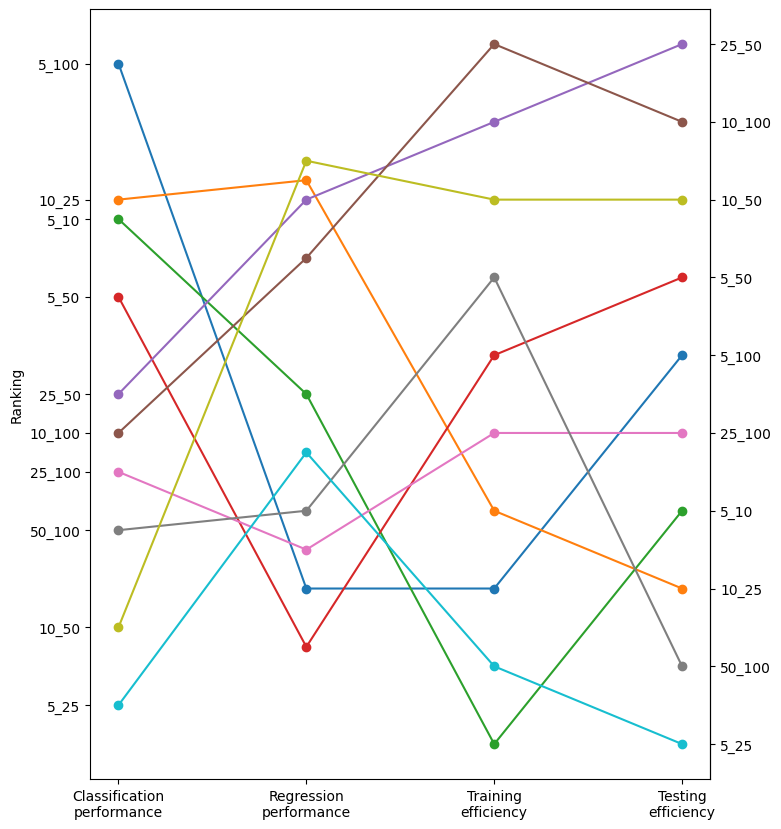

In [19]:
fig, ax = plt.subplots(figsize=(8, 10))
to_plot = pd.concat([
    cv_results.set_index('min_max')[['mean_ranking_cls']],
    cv_results.set_index('min_max')[['mean_ranking_reg']],
    cv_results.set_index('min_max')[['mean_ranking_fit_time']],
    cv_results.set_index('min_max')[['mean_ranking_score_time']]
    ], axis=1).sort_values(by='mean_ranking_cls')
for index, line in to_plot.iterrows():
    ax.plot([1,2,3,4], [line['mean_ranking_cls'], line['mean_ranking_reg'], line['mean_ranking_fit_time'], line['mean_ranking_score_time']], 'o-')

ax.set_yticks(to_plot['mean_ranking_cls'], list(to_plot.index))
yax2 = ax.secondary_yaxis("right")
yax2.set_yticks(to_plot['mean_ranking_score_time'], list(to_plot.index))
ax.set_xticks([1,2,3,4], ['Classification\nperformance', 'Regression\nperformance', 'Training\nefficiency', 'Testing\nefficiency'])
ax.set_ylabel('Ranking')
ax.invert_yaxis()
plt.show()


## Conclusion

By reading the chart, `5_100`(minimum grid length as 5 unit and maximum set as 100) shows the best performance in classification, and `10_50` shows the best in regression, averaging the metrics across different measurements.

While the ranking seems to have variation, the absolute differences by digits is not significant in our case (e.g., R2 variation is only at 0.01 level), meaning that all these parameter sets may be acceptable. At the end of the day, it may depend more on your domain knowledge than leaving this question to gridsearch.

The above situation and ranking may vary largely on a case-by-case bases, but generally I think median level gridding will be the best balance between overfitting and underfitting.

From another perspective, you may want to use larger grid size for efficiency, because AdaSTEM has speed bottleneck at the prediction/testing step. Increasing the grid size will also give you higher flexibility of longer-distance prediction, because larger spatiotemporal regions are covered. Adjust the gird based on your need.

## Finally, refit the model with the best parameters:

In [31]:
# Here we chose the best parameters for regression, although the difference is really not much.
best_params = {
    'grid_len_lower_threshold':cv_results.sort_values(by='mean_ranking_reg')['param_grid_len_lower_threshold'].iloc[0],
    'grid_len_upper_threshold':cv_results.sort_values(by='mean_ranking_reg')['param_grid_len_upper_threshold'].iloc[0]
}
print('Best parameters: ',best_params)

model = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),
    save_gridding_plot = True,
    ensemble_fold=10, 
    min_ensemble_required=7,
    # grid_len_upper_threshold=max_grid, # This is a gridsearch target
    # grid_len_lower_threshold=min_grid, # This is a gridsearch target
    points_lower_threshold=50,
    Spatio1='longitude',
    Spatio2 = 'latitude', 
    Temporal1 = 'DOY',
    use_temporal_to_train=True,
    njobs=4                  
)

from stemflow.model_selection import ST_train_test_split

X_train, X_test, y_train, y_test = ST_train_test_split(
    X, y, Spatio_blocks_count=50, Temporal_blocks_count=50, random_state=42, test_size=0.3
)
model = model.set_params(**best_params)
model = model.fit(X_train, y_train)


Best parameters:  {'grid_len_lower_threshold': 10, 'grid_len_upper_threshold': 50}


In [35]:
pred = model.predict(X_test)
pred = np.where(pred<0, 0, pred)
model.eval_STEM_res('hurdle', y_test.flatten()[pred>=0], pred[pred>=0]) # filter out NA


{'AUC': 0.7734218247408502,
 'kappa': 0.3919169104759538,
 'f1': 0.5259200702678963,
 'precision': 0.3953359391506444,
 'recall': 0.785320812129479,
 'average_precision': 0.34602773988349644,
 'Spearman_r': 0.47852384111905466,
 'Pearson_r': 0.21818167240532746,
 'R2': 0.008694469621954526,
 'MAE': 4.090158236189759,
 'MSE': 1256.4220053678623,
 'poisson_deviance_explained': 0.12527780086832163}

## Concluding mark

In [36]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,sklearn"))


Last updated: 2024-09-21T15:46:56.990649-05:00

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.1

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

stemflow  : 1.1.1
numpy     : 1.26.4
scipy     : 1.14.1
pandas    : 2.2.3
xgboost   : 2.0.3
tqdm      : 4.66.5
matplotlib: 3.9.2
h3pandas  : 0.2.6
geopandas : 0.14.3
sklearn   : 1.5.2

